In [ ]:
import sys
sys.path.append("/home/eickhoff/esx208/IR_Mech_Interp/MechIR_best_practices/src")

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from pingouin import partial_corr

from mechir.data import CatDataCollator, DotDataCollator, MechDataset

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from pyserini.search.lucene import LuceneSearcher
from pyserini.index.lucene import LuceneIndexReader

from collections import Counter
import math

In [7]:
tokenizer = AutoTokenizer.from_pretrained('crystina-z/monoELECTRA_LCE_nneg31')

FORMATTED_MODEL_NAME = 'crystina-z-monoELECTRA_LCE_nneg31'
MODEL_TYPE = 'cross'
PERTURBATION = 'TFC1'
K = 4000
BATCH_SIZE = 20

data_path = f'./data/patching_unnormalised/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_{K}_batch_size_{BATCH_SIZE}_patch_head.npy'
topk_file = f"./data/topk_my/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_topk_{K}.tsv"
doc_metrics_file = './data/TFC1-data_w_metrics.tsv'
query_metrics_file = './data/TREC-queries-data_w_metrics.tsv'

patching_results = np.load(data_path)
original_scores = np.load(data_path.replace('patch_head', 'original_scores'))
perturbed_scores = np.load(data_path.replace('patch_head', 'perturbed_scores'))
all_data_pd = pd.read_csv(topk_file, sep='\t')
all_data_pd['injected_term'] = all_data_pd['perturbed_text'].apply(lambda x: x.rsplit(' ', 1)[1])
doc_metrics_data = pd.read_csv(doc_metrics_file, sep='\t').drop_duplicates(subset=['docno'])
query_metrics_data = pd.read_csv(query_metrics_file, sep='\t').drop_duplicates(subset=['query_id'])
all_data_pd = all_data_pd.merge(doc_metrics_data, on=['docno'], suffixes=('', '_doc'))
all_data_pd = all_data_pd.merge(query_metrics_data, left_on=['qid'], right_on=['query_id'], suffixes=('', '_query'))

In [8]:
searcher = LuceneSearcher.from_prebuilt_index('msmarco-v1-passage-slim')
reader = LuceneIndexReader.from_prebuilt_index('msmarco-v1-passage-slim')

lucene-inverted.msmarco-v1-passage-slim.20221004.252b5e.tar.gz: 469MB [00:17, 27.4MB/s]                                                                                                                                                                                                               
Apr 17, 2025 4:57:41 PM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false


In [9]:
def get_tfidf(text, reader):
    terms = text.split()
    tf = Counter(terms)
    num_docs = reader.stats()['documents']
    
    tfidf_scores = dict()
    for term, term_count in tf.items():
        try:
            df = reader.get_term_counts(term)[0]
        except:
            df = 0
        if df > 0:
            tf = term_count / len(terms)
            idf = math.log(num_docs / df)
            tfidf_scores[term] = tf * idf
        else:
            tfidf_scores[term] = 0
    return tfidf_scores


def get_tf_injected_term(text, term):
    terms = text.split()
    tf = Counter(terms)
    if term in tf:
        return tf[term]
    else:
        return 0


def get_tfidf_injected_term(text, term, reader):
    tfidf_scores = get_tfidf(text, reader)
    if term in tfidf_scores:
        return tfidf_scores[term]
    else:
        return 0

In [10]:
all_data_pd['idf_injected_term'] = all_data_pd['injected_term'].apply(lambda x: get_tfidf(x, reader)[x])
all_data_pd['tf_injected_term'] = all_data_pd.apply(lambda x: get_tf_injected_term(x['text_tokenized'], x['injected_term']), axis=1)
all_data_pd['tfidf_injected_term'] = all_data_pd.apply(lambda x: get_tfidf_injected_term(x['text_tokenized'], x['injected_term'], reader), axis=1)
all_data_pd['injected_term_token_len'] = all_data_pd['injected_term'].apply(lambda x: len(tokenizer(x, add_special_tokens=False)['input_ids']))

In [11]:
def add_target_metrics(data, patching_results, original_scores, perturbed_scores):
    data['original_score'] = original_scores
    data['perturbed_score'] = perturbed_scores

    score_difference = perturbed_scores - original_scores
    data['score_delta'] = score_difference
    
    patching_results_normalised = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                np.abs((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis])))
    patching_results_normalised_square = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                        np.sqrt(1 + np.square((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis]))))
    patching_effect_normalised_clip = np.clip(patching_results_normalised, -1, 1)
    
    data['patching_effect_std'] = np.std(patching_results - original_scores[:, np.newaxis, np.newaxis], axis=(-1,-2))
    data['patching_effect_absolute_mean'] = np.mean(np.abs(patching_results - original_scores[:, np.newaxis, np.newaxis]), axis=(-1,-2))
    data['patching_effect_normalised_std'] = np.std(patching_results_normalised, axis=(-1,-2))
    data['patching_effect_normalised_absolute_mean'] = np.mean(np.abs(patching_results_normalised), axis=(-1,-2))
    data['patching_effect_normalised_square_std'] = np.std(patching_results_normalised_square, axis=(-1,-2))
    data['patching_effect_normalised_square_absolute_mean'] = np.mean(np.abs(patching_results_normalised_square), axis=(-1,-2))
    data['patching_effect_normalised_clip_std'] = np.std(patching_effect_normalised_clip, axis=(-1,-2))
    data['patching_effect_normalised_clip_absolute_mean'] = np.mean(np.abs(patching_effect_normalised_clip), axis=(-1,-2))
    
    return data

In [12]:
add_target_metrics(all_data_pd, patching_results, original_scores, perturbed_scores)

,qid,query,docno,text,relevance,perturbed,perturbed_score,rank,original_score,score_delta,...,tfidf_injected_term,injected_term_token_len,patching_effect_std,patching_effect_absolute_mean,patching_effect_normalised_std,patching_effect_normalised_absolute_mean,patching_effect_normalised_square_std,patching_effect_normalised_square_absolute_mean,patching_effect_normalised_clip_std,patching_effect_normalised_clip_absolute_mean
0,855410,what is theraderm used for,7128710,It is used to trap sunlight for the manufactur...,0,True,4.990025,0,-8.083547,13.073571,...,0.000000,3,0.700593,0.405368,0.053588,0.031007,0.053432,0.030916,0.053588,0.031007
1,855410,what is theraderm used for,3276027,"A mental grouping of similar things, events, a...",0,True,2.224427,30,-9.739095,11.963521,...,0.000000,3,0.551984,0.281880,0.046139,0.023562,0.045979,0.023480,0.046139,0.023562
2,855410,what is theraderm used for,8751749,": to add moisture to (something, such as a per...",0,True,2.215183,26,-9.171948,11.387131,...,0.000000,3,0.453133,0.248891,0.039793,0.021857,0.039641,0.021773,0.039793,0.021857
3,855410,what is theraderm used for,2945339,1 used to form adjectives Resembling or imitat...,0,True,1.944622,38,-9.353897,11.298519,...,0.000000,3,0.571451,0.276316,0.050578,0.024456,0.050381,0.024361,0.050578,0.024456
4,583468,what carvedilol used for,129686,Bottles of eau de toilette. Eau de toilette (F...,0,True,1.815684,226,-9.783665,11.599349,...,0.000000,3,0.479556,0.261826,0.041343,0.022573,0.041191,0.022489,0.041343,0.022573
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,405163,is caffeine an narcotic,7339772,Combination or cocktail drugs that contain a c...,3,True,-4.867818,258,-5.073496,0.205678,...,0.452777,3,0.016658,0.011814,0.080989,0.057438,0.016316,0.011572,0.080989,0.057438
3996,324585,how much money do motivational speakers make,405281,Fee structures for more experienced and profes...,3,True,2.870646,8,2.715543,0.155103,...,0.312759,2,0.009705,0.006859,0.062570,0.044224,0.009590,0.006778,0.062570,0.044224
3997,1132532,average annual income data analyst,6117745,What Data Analysts Make. Since the field of da...,3,True,1.993316,69,1.944495,0.048821,...,0.118065,1,0.007879,0.004875,0.161382,0.099858,0.007869,0.004869,0.156822,0.099157
3998,1113256,what is reba mcentire's net worth,7561111,Reba McEntire is a popular American singer wit...,3,True,5.701838,7,5.690272,0.011565,...,0.176354,1,0.002111,0.001500,0.182514,0.129679,0.002111,0.001500,0.182514,0.129679


In [13]:
# all_data_pd.to_csv(data_path.replace('_patch_head.npy', '_features.tsv'), sep='\t', index=False)

In [14]:
all_data_pd.columns

Index(['qid', 'query', 'docno', 'text', 'relevance', 'perturbed',
       'perturbed_score', 'rank', 'original_score', 'score_delta',
       'perturbed_text', 'injected_term', 'text_doc', 'text_tokenized',
       'text_stemmed', 'tfidf_mean', 'tfidf_std', 'doc_length',
       'english_probability', 'num_sentences', 'flesch_reading_ease',
       'flesch_kincaid_grade', 'gunning_fog', 'smog_index',
       'coleman_liau_index', 'automated_readability_index',
       'dale_chall_readability_score', 'gpt2_perplexity', 'query_id',
       'text_query', 'text_tokenized_query', 'text_stemmed_query',
       'tfidf_mean_query', 'tfidf_std_query', 'doc_length_query',
       'english_probability_query', 'flesch_reading_ease_query',
       'flesch_kincaid_grade_query', 'gunning_fog_query', 'smog_index_query',
       'coleman_liau_index_query', 'automated_readability_index_query',
       'dale_chall_readability_score_query', 'gpt2_perplexity_query',
       'idf_injected_term', 'tf_injected_term', 'tfid

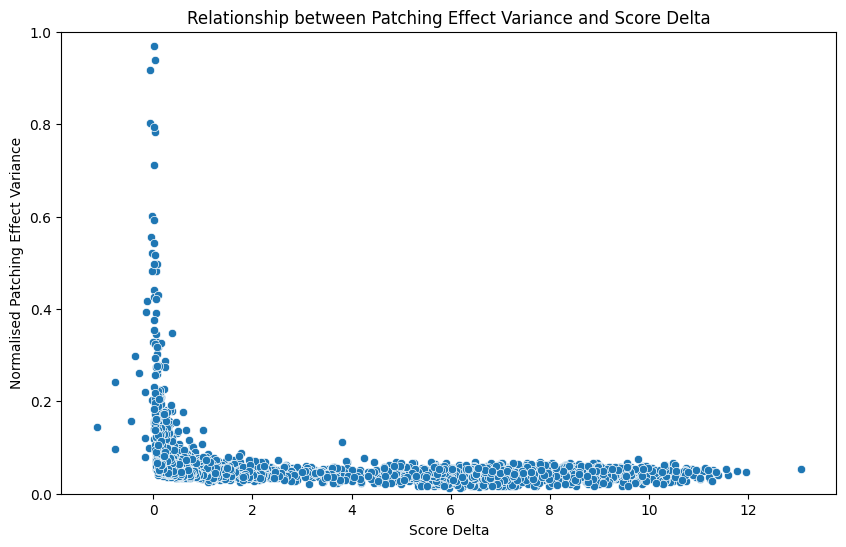

In [15]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=all_data_pd, y='patching_effect_normalised_std', x='score_delta')
plt.xlabel('Score Delta')
plt.ylabel('Normalised Patching Effect Variance')
plt.title('Relationship between Patching Effect Variance and Score Delta')
plt.ylim(0,1)
plt.show()

(1.0, 13.0)

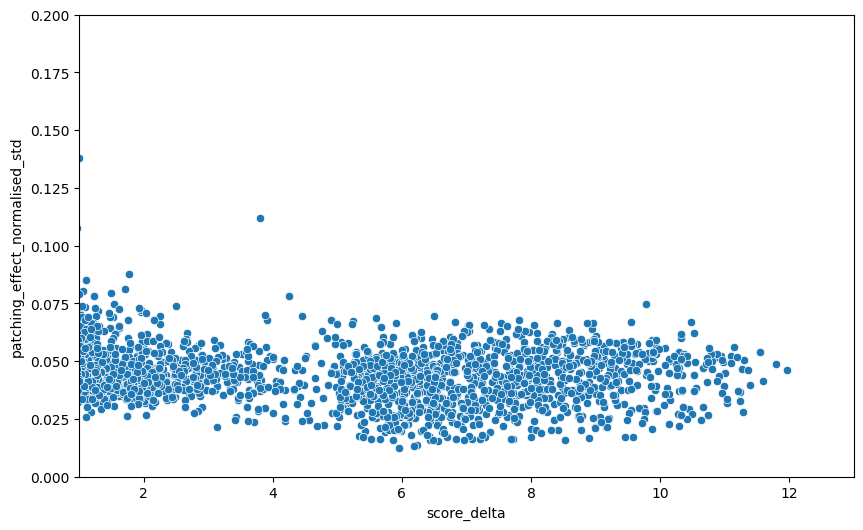

In [16]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=all_data_pd, y='patching_effect_normalised_std', x='score_delta')
plt.ylim(0,0.2)
plt.xlim(1, 13)

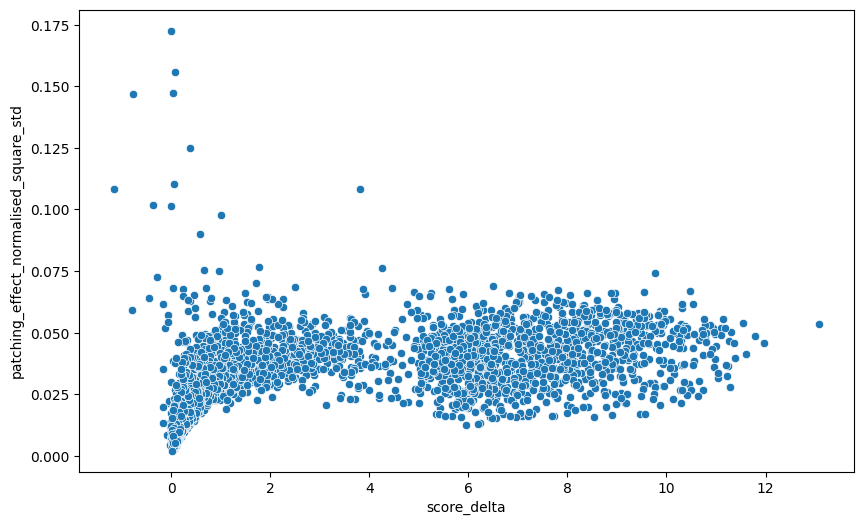

In [17]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=all_data_pd, y='patching_effect_normalised_square_std', x='score_delta')

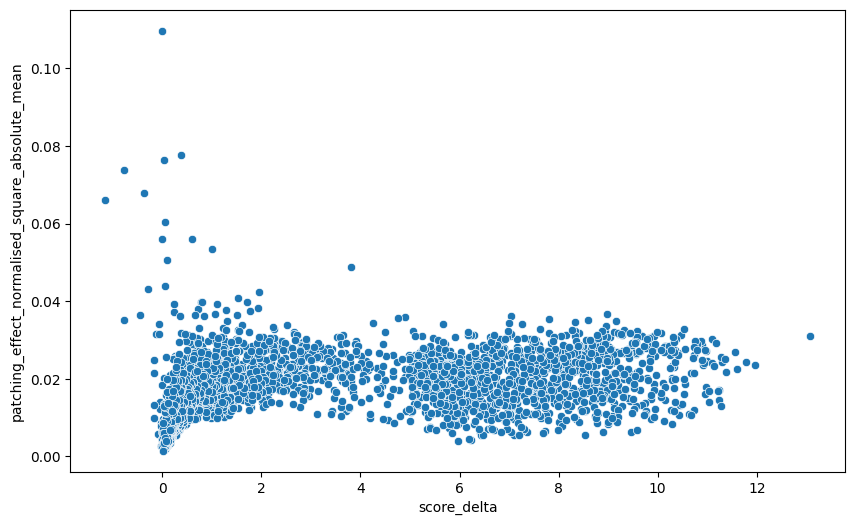

In [18]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=all_data_pd, y='patching_effect_normalised_square_absolute_mean', x='score_delta')

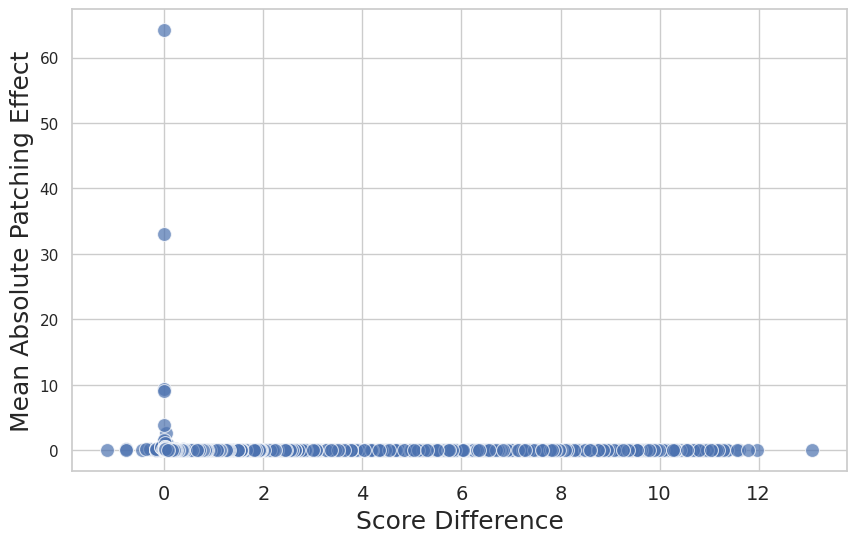

In [ ]:
# Create improved scatter plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Scatter plot with color palette and transparency
sns.scatterplot(data=all_data_pd, y='v', x='score_delta', s=100, alpha=0.7)

# Customize labels and title
plt.xlabel('Score Difference', fontsize=18)
plt.ylabel('Mean Absolute Patching Effect', fontsize=18)
# plt.ylabel(None)
# plt.title('Relationship between Mean Absolute Patching Effect and Score Difference', fontsize=20)

# Add grid
plt.grid(True)
plt.xticks(fontsize=14)

# Save the plot as an image file
# plt.savefig('/mnt/qb/work/eickhoff/esx208/MechIR/notebooks/plots/cross_encoder_scatter_plot_no_penalty.pdf', bbox_inches='tight')
plt.show()

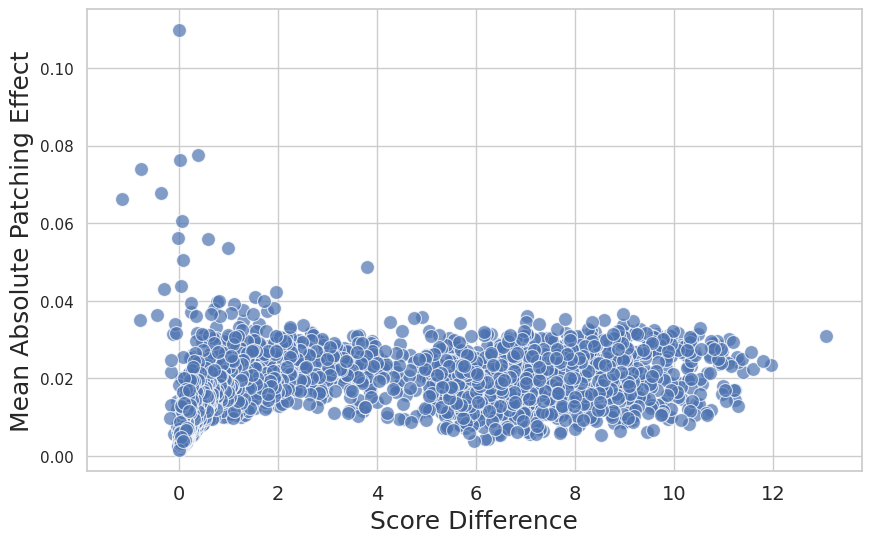

In [20]:
# Create improved scatter plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Scatter plot with color palette and transparency
sns.scatterplot(data=all_data_pd, y='patching_effect_normalised_square_absolute_mean', x='score_delta', s=100, alpha=0.7)

# Customize labels and title
plt.xlabel('Score Difference', fontsize=18)
plt.ylabel('Mean Absolute Patching Effect', fontsize=18)
# plt.title('Relationship between Mean Absolute Patching Effect and Score Difference', fontsize=20)

# Add grid
plt.grid(True)
plt.xticks(fontsize=14)

# Save the plot as an image file
# plt.savefig('/mnt/qb/work/eickhoff/esx208/MechIR/notebooks/plots/cross_encoder_scatter_plot_with_penalty.pdf', bbox_inches='tight')
plt.show()

In [17]:
def output_correlations(properties, target_metrics, data):
    correlations = dict()
    for target_metric in target_metrics:
        correlations[target_metric] = dict()
        for property in properties:
            correlation = spearmanr(data[property], data[target_metric])
            correlations[target_metric][property] = {'spearman': np.round(correlation.correlation, 3), 
                                                     'p-value': np.round(correlation.pvalue, 3)}
    return pd.DataFrame(correlations)

target_metrics = ['patching_effect_normalised_std', 'patching_effect_normalised_absolute_mean',
                  'patching_effect_normalised_square_std', 'patching_effect_normalised_square_absolute_mean', 
                  'patching_effect_normalised_clip_std', 'patching_effect_normalised_clip_absolute_mean']

properties = ['score_delta', 'relevance', 'idf_injected_term', 'tfidf_injected_term', 'tfidf_mean', 'tfidf_std', 'english_probability', 'flesch_reading_ease', 'gunning_fog', 
              'smog_index', 'coleman_liau_index', 'automated_readability_index', 'dale_chall_readability_score', 'gpt2_perplexity', 
              'tfidf_mean_query', 'tfidf_std_query', 'english_probability_query', 'flesch_reading_ease_query', 'gunning_fog_query', 
              'smog_index_query', 'coleman_liau_index_query', 'automated_readability_index_query', 'dale_chall_readability_score_query','gpt2_perplexity_query']
output_correlations(properties, target_metrics, all_data_pd)

/scratch_local/esx208-1140848/tmp/ipykernel_1630800/905372591.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation = spearmanr(data[property], data[target_metric])


,patching_effect_normalised_std,patching_effect_normalised_absolute_mean,patching_effect_normalised_square_std,patching_effect_normalised_square_absolute_mean,patching_effect_normalised_clip_std,patching_effect_normalised_clip_absolute_mean
score_delta,"{'spearman': -0.537, 'p-value': 0.0}","{'spearman': -0.71, 'p-value': 0.0}","{'spearman': 0.72, 'p-value': 0.0}","{'spearman': 0.582, 'p-value': 0.0}","{'spearman': -0.537, 'p-value': 0.0}","{'spearman': -0.71, 'p-value': 0.0}"
relevance,"{'spearman': 0.428, 'p-value': 0.0}","{'spearman': 0.561, 'p-value': 0.0}","{'spearman': -0.519, 'p-value': 0.0}","{'spearman': -0.408, 'p-value': 0.0}","{'spearman': 0.428, 'p-value': 0.0}","{'spearman': 0.561, 'p-value': 0.0}"
idf_injected_term,"{'spearman': -0.024, 'p-value': 0.122}","{'spearman': -0.133, 'p-value': 0.0}","{'spearman': 0.35, 'p-value': 0.0}","{'spearman': 0.282, 'p-value': 0.0}","{'spearman': -0.024, 'p-value': 0.121}","{'spearman': -0.133, 'p-value': 0.0}"
tfidf_injected_term,"{'spearman': 0.332, 'p-value': 0.0}","{'spearman': 0.492, 'p-value': 0.0}","{'spearman': -0.499, 'p-value': 0.0}","{'spearman': -0.378, 'p-value': 0.0}","{'spearman': 0.332, 'p-value': 0.0}","{'spearman': 0.492, 'p-value': 0.0}"
tfidf_mean,"{'spearman': -0.111, 'p-value': 0.0}","{'spearman': -0.08, 'p-value': 0.0}","{'spearman': 0.136, 'p-value': 0.0}","{'spearman': 0.167, 'p-value': 0.0}","{'spearman': -0.111, 'p-value': 0.0}","{'spearman': -0.08, 'p-value': 0.0}"
tfidf_std,"{'spearman': -0.082, 'p-value': 0.0}","{'spearman': -0.078, 'p-value': 0.0}","{'spearman': 0.074, 'p-value': 0.0}","{'spearman': 0.071, 'p-value': 0.0}","{'spearman': -0.082, 'p-value': 0.0}","{'spearman': -0.078, 'p-value': 0.0}"
english_probability,"{'spearman': -0.005, 'p-value': 0.769}","{'spearman': -0.002, 'p-value': 0.903}","{'spearman': 0.008, 'p-value': 0.628}","{'spearman': 0.011, 'p-value': 0.479}","{'spearman': -0.005, 'p-value': 0.768}","{'spearman': -0.002, 'p-value': 0.903}"
flesch_reading_ease,"{'spearman': -0.069, 'p-value': 0.0}","{'spearman': -0.054, 'p-value': 0.001}","{'spearman': -0.072, 'p-value': 0.0}","{'spearman': -0.087, 'p-value': 0.0}","{'spearman': -0.069, 'p-value': 0.0}","{'spearman': -0.054, 'p-value': 0.001}"
gunning_fog,"{'spearman': 0.048, 'p-value': 0.003}","{'spearman': 0.036, 'p-value': 0.025}","{'spearman': 0.054, 'p-value': 0.001}","{'spearman': 0.066, 'p-value': 0.0}","{'spearman': 0.048, 'p-value': 0.003}","{'spearman': 0.036, 'p-value': 0.025}"
smog_index,"{'spearman': 0.129, 'p-value': 0.0}","{'spearman': 0.09, 'p-value': 0.0}","{'spearman': -0.057, 'p-value': 0.0}","{'spearman': -0.075, 'p-value': 0.0}","{'spearman': 0.129, 'p-value': 0.0}","{'spearman': 0.09, 'p-value': 0.0}"


In [24]:
target_metrics = ['patching_effect_normalised_square_std', 'patching_effect_normalised_square_absolute_mean']

properties = ['score_delta', 'relevance', 'tfidf_injected_term', 'idf_injected_term', 'tfidf_mean', 'tfidf_std', 'english_probability', 'flesch_reading_ease', 'gunning_fog', 
              'smog_index', 'coleman_liau_index', 'automated_readability_index', 'dale_chall_readability_score', 'gpt2_perplexity', 
              'tfidf_mean_query', 'tfidf_std_query', 'english_probability_query', 'flesch_reading_ease_query', 'gunning_fog_query', 
              'smog_index_query', 'coleman_liau_index_query', 'automated_readability_index_query', 'dale_chall_readability_score_query','gpt2_perplexity_query']
correlations_table = output_correlations(properties, target_metrics, all_data_pd)
correlations_table.rename(columns={'patching_effect_normalised_square_std': 'Std of Patching Effect (w/ Penalty)',
                                   'patching_effect_normalised_square_absolute_mean': 'Mean Absolute Patching effect (w/ Penalty)'}, inplace=True)

/scratch_local/esx208-1106524/tmp/ipykernel_422701/905372591.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation = spearmanr(data[property], data[target_metric])


In [25]:
all_data_pd_scores_cut = all_data_pd[(all_data_pd['score_delta'] > 1)]

In [26]:
target_metrics = ['patching_effect_normalised_square_std', 'patching_effect_normalised_square_absolute_mean']

properties = ['score_delta', 'relevance', 'tfidf_injected_term', 'idf_injected_term', 'tfidf_mean', 'tfidf_std', 'english_probability', 'flesch_reading_ease', 'gunning_fog', 
              'smog_index', 'coleman_liau_index', 'automated_readability_index', 'dale_chall_readability_score', 'gpt2_perplexity', 
              'tfidf_mean_query', 'tfidf_std_query', 'english_probability_query', 'flesch_reading_ease_query', 'gunning_fog_query', 
              'smog_index_query', 'coleman_liau_index_query', 'automated_readability_index_query', 'dale_chall_readability_score_query','gpt2_perplexity_query']
correlations_table_scores_cut = output_correlations(properties, target_metrics, all_data_pd_scores_cut)
correlations_table_scores_cut.rename(columns={'patching_effect_normalised_square_std': 'Std of Patching Effect (w/ Penalty)',
                                   'patching_effect_normalised_square_absolute_mean': 'Mean Absolute Patching effect (w/ Penalty)'}, inplace=True)

/scratch_local/esx208-1106524/tmp/ipykernel_422701/905372591.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation = spearmanr(data[property], data[target_metric])


In [29]:
correlations_table_scores_cut.sort_values(by='Std of Patching Effect (w/ Penalty)', key=lambda x: x.apply(lambda y: -np.abs(y['spearman'])))

,Std of Patching Effect (w/ Penalty),Mean Absolute Patching effect (w/ Penalty)
idf_injected_term,"{'spearman': 0.281, 'p-value': 0.0}","{'spearman': 0.094, 'p-value': 0.0}"
score_delta,"{'spearman': 0.254, 'p-value': 0.0}","{'spearman': 0.079, 'p-value': 0.0}"
english_probability_query,"{'spearman': 0.161, 'p-value': 0.0}","{'spearman': 0.199, 'p-value': 0.0}"
dale_chall_readability_score_query,"{'spearman': -0.159, 'p-value': 0.0}","{'spearman': -0.195, 'p-value': 0.0}"
flesch_reading_ease_query,"{'spearman': 0.142, 'p-value': 0.0}","{'spearman': 0.138, 'p-value': 0.0}"
tfidf_injected_term,"{'spearman': -0.138, 'p-value': 0.0}","{'spearman': -0.081, 'p-value': 0.0}"
gpt2_perplexity,"{'spearman': -0.137, 'p-value': 0.0}","{'spearman': -0.119, 'p-value': 0.0}"
tfidf_std_query,"{'spearman': 0.134, 'p-value': 0.0}","{'spearman': -0.04, 'p-value': 0.066}"
automated_readability_index_query,"{'spearman': -0.126, 'p-value': 0.0}","{'spearman': -0.094, 'p-value': 0.0}"
coleman_liau_index_query,"{'spearman': -0.112, 'p-value': 0.0}","{'spearman': -0.046, 'p-value': 0.034}"


In [30]:
correlations_table.sort_values(by='Std of Patching Effect (w/ Penalty)', key=lambda x: x.apply(lambda y: -np.abs(y['spearman'])))

,Std of Patching Effect (w/ Penalty),Mean Absolute Patching effect (w/ Penalty)
score_delta,"{'spearman': 0.72, 'p-value': 0.0}","{'spearman': 0.582, 'p-value': 0.0}"
relevance,"{'spearman': -0.519, 'p-value': 0.0}","{'spearman': -0.408, 'p-value': 0.0}"
tfidf_injected_term,"{'spearman': -0.499, 'p-value': 0.0}","{'spearman': -0.378, 'p-value': 0.0}"
idf_injected_term,"{'spearman': 0.35, 'p-value': 0.0}","{'spearman': 0.282, 'p-value': 0.0}"
tfidf_std_query,"{'spearman': 0.35, 'p-value': 0.0}","{'spearman': 0.249, 'p-value': 0.0}"
tfidf_mean_query,"{'spearman': 0.217, 'p-value': 0.0}","{'spearman': 0.154, 'p-value': 0.0}"
gunning_fog_query,"{'spearman': -0.156, 'p-value': 0.0}","{'spearman': -0.122, 'p-value': 0.0}"
tfidf_mean,"{'spearman': 0.136, 'p-value': 0.0}","{'spearman': 0.167, 'p-value': 0.0}"
coleman_liau_index_query,"{'spearman': -0.124, 'p-value': 0.0}","{'spearman': -0.06, 'p-value': 0.0}"
flesch_reading_ease_query,"{'spearman': 0.114, 'p-value': 0.0}","{'spearman': 0.08, 'p-value': 0.0}"


In [52]:
def output_partial_correlations(properties, target_metrics, data):
    correlations = dict()
    for target_metric in target_metrics:
        correlations[target_metric] = dict()
        for property in properties:
            if property != 'score_delta':
                spearman_partial = partial_corr(data=all_data_pd, x=target_metric, y=property, covar='score_delta', method='spearman')
                correlations[target_metric][property] = {'spearman_partial': np.round(spearman_partial['r'].values[0], 3), 
                                                        'p-value': np.round(spearman_partial['p-val'].values[0], 3)}
    return pd.DataFrame(correlations)


target_metrics = ['patching_effect_std', 'patching_effect_absolute_mean']

properties = ['score_delta', 'relevance', 'tfidf_injected_term', 'idf_injected_term', 'tf_injected_term', 'tfidf_mean', 'tfidf_std', 'english_probability', 'flesch_reading_ease', 'gunning_fog', 
              'smog_index', 'coleman_liau_index', 'automated_readability_index', 'dale_chall_readability_score', 'gpt2_perplexity', 
              'tfidf_mean_query', 'tfidf_std_query', 'english_probability_query', 'flesch_reading_ease_query', 'gunning_fog_query', 
              'smog_index_query', 'coleman_liau_index_query', 'automated_readability_index_query', 'dale_chall_readability_score_query','gpt2_perplexity_query']
correlations_table = output_partial_correlations(properties, target_metrics, all_data_pd)
correlations_table.rename(columns={'patching_effect_std': 'Std of Unnormalised Patching Effect',
                                   'patching_effect_absolute_mean': 'Mean Absolute Unnormalosed Patching effect'}, inplace=True)
correlations_table = correlations_table.sort_values(by='Std of Unnormalised Patching Effect', key=lambda x: x.apply(lambda y: -np.abs(y['spearman_partial'])))

/scratch_local/esx208-1106524/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/scratch_local/esx208-1106524/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix
/scratch_local/esx208-1106524/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/scratch_local/esx208-1106524/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix


In [53]:
correlations_table

,Std of Unnormalised Patching Effect,Mean Absolute Unnormalosed Patching effect
idf_injected_term,"{'spearman_partial': 0.213, 'p-value': 0.0}","{'spearman_partial': 0.228, 'p-value': 0.0}"
coleman_liau_index,"{'spearman_partial': 0.104, 'p-value': 0.0}","{'spearman_partial': 0.11, 'p-value': 0.0}"
flesch_reading_ease,"{'spearman_partial': -0.096, 'p-value': 0.0}","{'spearman_partial': -0.106, 'p-value': 0.0}"
tf_injected_term,"{'spearman_partial': -0.094, 'p-value': 0.0}","{'spearman_partial': -0.028, 'p-value': 0.081}"
tfidf_std_query,"{'spearman_partial': 0.089, 'p-value': 0.0}","{'spearman_partial': 0.019, 'p-value': 0.224}"
tfidf_mean_query,"{'spearman_partial': 0.077, 'p-value': 0.0}","{'spearman_partial': 0.038, 'p-value': 0.016}"
automated_readability_index,"{'spearman_partial': 0.076, 'p-value': 0.0}","{'spearman_partial': 0.083, 'p-value': 0.0}"
english_probability_query,"{'spearman_partial': 0.068, 'p-value': 0.0}","{'spearman_partial': 0.089, 'p-value': 0.0}"
gunning_fog,"{'spearman_partial': 0.06, 'p-value': 0.0}","{'spearman_partial': 0.065, 'p-value': 0.0}"
tfidf_mean,"{'spearman_partial': 0.053, 'p-value': 0.001}","{'spearman_partial': 0.132, 'p-value': 0.0}"


In [54]:
def train_catboost_model(df, target_column, feature_columns):
    # Prepare data
    X = df[feature_columns]
    y = df[target_column]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Initialize model
    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=6,
        loss_function='RMSE',
        eval_metric='RMSE',
        random_seed=42,
        early_stopping_rounds=50,
        verbose=100
    )
    
    # Train model
    model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        plot=True
    )
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Evaluate
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return {
        'model': model,
        'rmse': rmse,
        'r2': r2,
        'feature_importance': feature_importance,
        'predictions': y_pred
    }

In [55]:
results = train_catboost_model(all_data_pd, 'patching_effect_normalised_square_std', properties)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0137468	test: 0.0142567	best: 0.0142567 (0)	total: 2.59ms	remaining: 2.59s
100:	learn: 0.0069547	test: 0.0097380	best: 0.0097251 (85)	total: 152ms	remaining: 1.36s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.009725067383
bestIteration = 85

Shrink model to first 86 iterations.


In [56]:
results

{'model': <catboost.core.CatBoostRegressor at 0x7f434e6ab910>,
 'rmse': 0.00972506738282623,
 'r2': 0.5745228420018031,
 'feature_importance':                                feature  importance
 0                          score_delta   42.791502
 3                    idf_injected_term   10.887264
 1                            relevance    8.597475
 15                    tfidf_mean_query    4.962252
 16                     tfidf_std_query    3.539531
 4                     tf_injected_term    2.681842
 14                     gpt2_perplexity    2.636040
 19                   gunning_fog_query    2.561598
 24               gpt2_perplexity_query    2.394222
 18           flesch_reading_ease_query    2.187927
 5                           tfidf_mean    1.997031
 17           english_probability_query    1.859441
 21            coleman_liau_index_query    1.759843
 23  dale_chall_readability_score_query    1.637436
 10                          smog_index    1.382362
 6                        

In [57]:
results_mean = train_catboost_model(all_data_pd, 'patching_effect_normalised_square_absolute_mean', properties)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0070120	test: 0.0077182	best: 0.0077182 (0)	total: 2.96ms	remaining: 2.96s
100:	learn: 0.0039224	test: 0.0056656	best: 0.0056640 (99)	total: 152ms	remaining: 1.35s
200:	learn: 0.0032768	test: 0.0056197	best: 0.0056197 (200)	total: 307ms	remaining: 1.22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.005616810604
bestIteration = 206

Shrink model to first 207 iterations.


In [58]:
results_mean

{'model': <catboost.core.CatBoostRegressor at 0x7f434e276d60>,
 'rmse': 0.00561681060437043,
 'r2': 0.5030604479034024,
 'feature_importance':                                feature  importance
 0                          score_delta   33.026259
 3                    idf_injected_term   11.399380
 1                            relevance    6.272591
 15                    tfidf_mean_query    4.866058
 5                           tfidf_mean    4.859043
 14                     gpt2_perplexity    4.017613
 24               gpt2_perplexity_query    4.009608
 6                            tfidf_std    2.652286
 13        dale_chall_readability_score    2.627731
 16                     tfidf_std_query    2.595873
 22   automated_readability_index_query    2.527130
 19                   gunning_fog_query    2.350299
 11                  coleman_liau_index    2.070639
 23  dale_chall_readability_score_query    2.064753
 18           flesch_reading_ease_query    2.007644
 8                  flesch

In [34]:
all_data_pd.sort_values(by='tfidf_injected_term', ascending=False).head(1000)

,qid,query,docno,text,relevance,perturbed,perturbed_score,rank,original_score,score_delta,...,tf_injected_term,tfidf_injected_term,patching_effect_std,patching_effect_absolute_mean,patching_effect_normalised_std,patching_effect_normalised_absolute_mean,patching_effect_normalised_square_std,patching_effect_normalised_square_absolute_mean,patching_effect_normalised_clip_std,patching_effect_normalised_clip_absolute_mean
2510,135802,definition of laudable,8692624,"(comparative more laudable, superlative most l...",2,True,4.406727,8,3.782180,0.624547,...,7,2.050709,0.026063,0.012510,0.041731,0.020030,0.022106,0.010610,0.041731,0.020030
3852,1112341,what is the daily life of thai people,4595993,"Muay Thai. Muay Thai (Thai: มวยไทย, rtgs: Muai...",3,True,-7.789141,237,-7.940962,0.151821,...,5,1.345881,0.014714,0.009827,0.096916,0.064730,0.014547,0.009716,0.096916,0.064730
3756,1127540,meaning of shebang,2044368,Definition of shebang. : everything involved i...,3,True,5.410295,0,5.166280,0.244016,...,2,1.320459,0.016315,0.011813,0.066859,0.048411,0.015850,0.011476,0.066859,0.048411
3609,768208,what is mamey,52155,Mamey Sapote. Mamey Sapote (Pouteria sapota) (...,3,True,5.464853,2,5.260576,0.204277,...,4,1.205981,0.016802,0.010676,0.082252,0.052262,0.016462,0.010460,0.082252,0.052262
3710,1030303,who is aziz hashim,8726436,Share on LinkedInShare on FacebookShare on Twi...,3,True,1.279508,12,1.215960,0.063547,...,4,1.156653,0.007409,0.005120,0.116584,0.080576,0.007394,0.005110,0.116584,0.080576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374,1117099,what is a active margin,3435986,"When plates collide, earthquakes and volcanic ...",1,True,-6.880700,383,-8.131755,1.251055,...,1,0.099712,0.053390,0.031395,0.042676,0.025095,0.033335,0.019602,0.042676,0.025095
2954,1133167,how is the weather in jamaica,6143,"During the hurricane season, Ocho Rios experie...",2,True,0.952969,331,0.637347,0.315622,...,1,0.099631,0.023171,0.014889,0.073414,0.047172,0.022097,0.014198,0.073414,0.047172
3712,1117099,what is a active margin,3543106,An active plate margin is an actual plate boun...,3,True,4.625731,2,4.507631,0.118099,...,1,0.099251,0.013449,0.009016,0.113880,0.076343,0.013356,0.008954,0.113880,0.076343
3738,640502,what does it mean if your tsh is low,6702288,There are 2 reasons that could be the cause be...,3,True,0.880449,189,0.727619,0.152830,...,1,0.099183,0.012926,0.008236,0.084576,0.053893,0.012777,0.008142,0.084576,0.053893


In [36]:
patching_results_normalised_square = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                      np.sqrt(1 + np.square((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis]))))

In [49]:
patching_results_normalised = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                            (perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis]))

<Axes: >

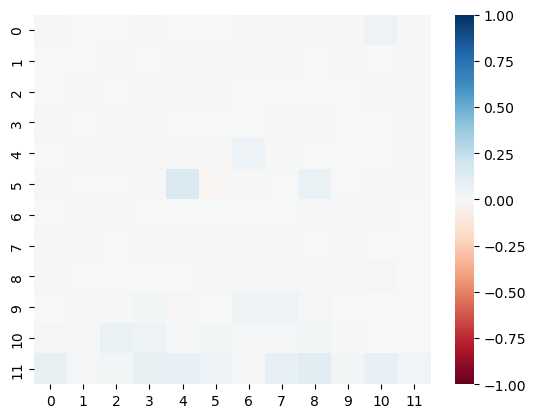

In [50]:
sns.heatmap(
    patching_results_normalised_square.mean(axis=0),
    vmax=1,
    vmin=-1,
    cmap='RdBu'
)

<Axes: >

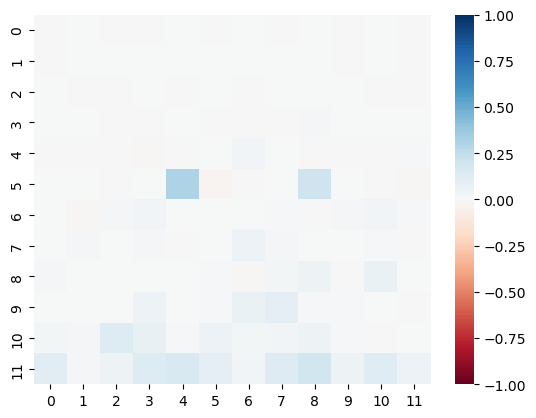

In [43]:
sns.heatmap(
    patching_results_normalised_square[all_data_pd.sort_values(by='idf_injected_term', ascending=False).head(100).index].mean(axis=0),
    vmax=1,
    vmin=-1,
    cmap='RdBu'
)

<Axes: >

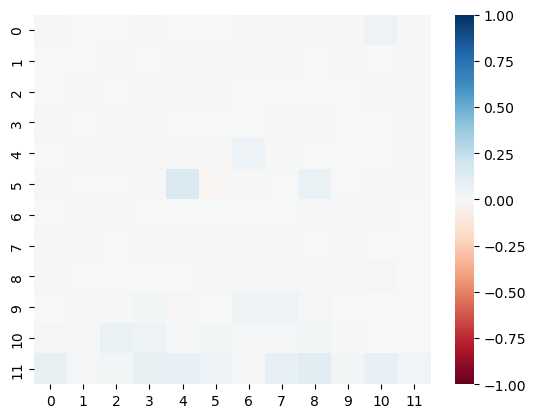

In [42]:
sns.heatmap(
    patching_results_normalised_square[all_data_pd.sort_values(by='score_delta', ascending=False).index].mean(axis=0),
    vmax=1,
    vmin=-1,
    cmap='RdBu'
)

Let's try to decorrelate the target metric with the score difference

In [20]:
properties = ['score_delta', 'relevance', 'injected_term_token_len', 'tfidf_injected_term', 'idf_injected_term', 'tf_injected_term', 'tfidf_mean', 'tfidf_std', 'english_probability', 'flesch_reading_ease', 'gunning_fog', 
              'smog_index', 'coleman_liau_index', 'automated_readability_index', 'dale_chall_readability_score', 'gpt2_perplexity', 
              'tfidf_mean_query', 'tfidf_std_query', 'english_probability_query', 'flesch_reading_ease_query', 'gunning_fog_query', 
              'smog_index_query', 'coleman_liau_index_query', 'automated_readability_index_query', 'dale_chall_readability_score_query','gpt2_perplexity_query']

In [21]:
from sklearn.linear_model import LinearRegression

def decorrelate_columns(df, target_col, feature_col, new_col_name=None):
    if new_col_name is None:
        new_col_name = f"{target_col}_decorrelated"

    model = LinearRegression()
    X = df[[feature_col]].values.reshape(-1, 1)
    y = df[target_col].values
    model.fit(X, y)

    predicted = model.predict(X)

    df[new_col_name] = df[target_col] - predicted

    print(f"Correlation before: {df[target_col].corr(df[feature_col]):.4f}")
    print(f"Correlation after: {df[new_col_name].corr(df[feature_col]):.4f}")

    return df

In [22]:
def train_catboost_model(df, target_column, feature_columns):
    X = df[feature_columns]
    y = df[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=6,
        loss_function='RMSE',
        eval_metric='RMSE',
        random_seed=42,
        early_stopping_rounds=20,
        verbose=100
    )
    
    model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        plot=True
    )
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return {
        'model': model,
        'rmse': rmse,
        'r2': r2,
        'feature_importance': feature_importance,
        'predictions': y_pred
    }

In [33]:
decorrelate_columns(all_data_pd, 'patching_effect_absolute_mean', 'score_delta', new_col_name='patching_effect_absolute_mean_decorrelated')
decorrelate_columns(all_data_pd, 'patching_effect_std', 'score_delta', new_col_name='patching_effect_std_decorrelated')

Correlation before: 0.9124
Correlation after: 0.0000
Correlation before: 0.9358
Correlation after: 0.0000


,qid,query,docno,text,relevance,perturbed,perturbed_score,rank,original_score,score_delta,...,patching_effect_std,patching_effect_absolute_mean,patching_effect_normalised_std,patching_effect_normalised_absolute_mean,patching_effect_normalised_square_std,patching_effect_normalised_square_absolute_mean,patching_effect_normalised_clip_std,patching_effect_normalised_clip_absolute_mean,patching_effect_absolute_mean_decorrelated,patching_effect_std_decorrelated
0,855410,what is theraderm used for,7128710,It is used to trap sunlight for the manufactur...,0,True,4.990025,0,-8.083547,13.073571,...,0.700593,0.405368,0.053588,0.031007,0.053432,0.030916,0.053588,0.031007,0.133807,0.146108
1,855410,what is theraderm used for,3276027,"A mental grouping of similar things, events, a...",0,True,2.224427,30,-9.739095,11.963521,...,0.551984,0.281880,0.046139,0.023562,0.045979,0.023480,0.046139,0.023562,0.032881,0.044108
2,855410,what is theraderm used for,8751749,": to add moisture to (something, such as a per...",0,True,2.215183,26,-9.171948,11.387131,...,0.453133,0.248891,0.039793,0.021857,0.039641,0.021773,0.039793,0.021857,0.011606,-0.030542
3,855410,what is theraderm used for,2945339,1 used to form adjectives Resembling or imitat...,0,True,1.944622,38,-9.353897,11.298519,...,0.571451,0.276316,0.050578,0.024456,0.050381,0.024361,0.050578,0.024456,0.040832,0.091498
4,583468,what carvedilol used for,129686,Bottles of eau de toilette. Eau de toilette (F...,0,True,1.815684,226,-9.783665,11.599349,...,0.479556,0.261826,0.041343,0.022573,0.041191,0.022489,0.041343,0.022573,0.020229,-0.013029
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,405163,is caffeine an narcotic,7339772,Combination or cocktail drugs that contain a c...,3,True,-4.867818,258,-5.073496,0.205678,...,0.016658,0.011814,0.080989,0.057438,0.016316,0.011572,0.080989,0.057438,0.001785,0.002469
3996,324585,how much money do motivational speakers make,405281,Fee structures for more experienced and profes...,3,True,2.870646,8,2.715543,0.155103,...,0.009705,0.006859,0.062570,0.044224,0.009590,0.006778,0.062570,0.044224,-0.002141,-0.002360
3997,1132532,average annual income data analyst,6117745,What Data Analysts Make. Since the field of da...,3,True,1.993316,69,1.944495,0.048821,...,0.007879,0.004875,0.161382,0.099858,0.007869,0.004869,0.156822,0.099157,-0.001965,0.000277
3998,1113256,what is reba mcentire's net worth,7561111,Reba McEntire is a popular American singer wit...,3,True,5.701838,7,5.690272,0.011565,...,0.002111,0.001500,0.182514,0.129679,0.002111,0.001500,0.182514,0.129679,-0.004583,-0.003927


<Axes: xlabel='score_delta', ylabel='patching_effect_absolute_mean_decorrelated'>

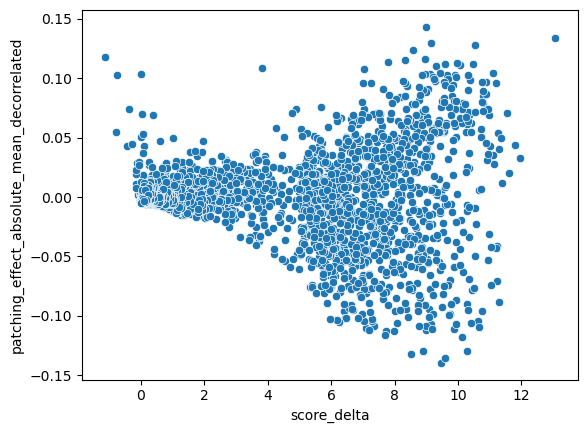

In [34]:
sns.scatterplot(data=all_data_pd, y='patching_effect_absolute_mean_decorrelated', x='score_delta')

In [35]:
results_mean = train_catboost_model(all_data_pd, 'patching_effect_absolute_mean_decorrelated', properties)

TBB Warning: The number of workers is currently limited to 15. The request for 63 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0276271	test: 0.0309875	best: 0.0309875 (0)	total: 49.8ms	remaining: 49.7s
100:	learn: 0.0188714	test: 0.0279709	best: 0.0279709 (100)	total: 162ms	remaining: 1.45s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.02782846371
bestIteration = 135

Shrink model to first 136 iterations.


In [36]:
results_mean

{'model': <catboost.core.CatBoostRegressor at 0x7f394adabfa0>,
 'rmse': 0.027828463711872715,
 'r2': 0.21505776919184738,
 'feature_importance':                                feature  importance
 0                          score_delta   21.151446
 15                     gpt2_perplexity   10.360384
 2              injected_term_token_len    8.628310
 1                            relevance    7.279530
 9                  flesch_reading_ease    5.439343
 12                  coleman_liau_index    4.194672
 6                           tfidf_mean    4.142466
 7                            tfidf_std    4.040294
 4                    idf_injected_term    3.417621
 8                  english_probability    3.275014
 10                         gunning_fog    3.203765
 24  dale_chall_readability_score_query    3.082498
 13         automated_readability_index    2.998775
 19           flesch_reading_ease_query    2.955512
 16                    tfidf_mean_query    2.657061
 14        dale_chall_re

In [37]:
results_std = train_catboost_model(all_data_pd, 'patching_effect_std_decorrelated', properties)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0477568	test: 0.0543946	best: 0.0543946 (0)	total: 3.14ms	remaining: 3.14s
100:	learn: 0.0324447	test: 0.0491015	best: 0.0490789 (96)	total: 112ms	remaining: 993ms
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.04907885333
bestIteration = 96

Shrink model to first 97 iterations.


In [38]:
results_std

{'model': <catboost.core.CatBoostRegressor at 0x7f3988360b80>,
 'rmse': 0.04907885332792861,
 'r2': 0.2029470087274945,
 'feature_importance':                                feature  importance
 0                          score_delta   15.998951
 2              injected_term_token_len   11.941866
 1                            relevance   10.866885
 15                     gpt2_perplexity    8.782590
 4                    idf_injected_term    8.195728
 9                  flesch_reading_ease    5.086437
 19           flesch_reading_ease_query    4.722696
 12                  coleman_liau_index    4.039560
 6                           tfidf_mean    3.560386
 7                            tfidf_std    3.278418
 23   automated_readability_index_query    2.683682
 8                  english_probability    2.616947
 17                     tfidf_std_query    2.588949
 14        dale_chall_readability_score    2.487522
 25               gpt2_perplexity_query    2.357623
 22            coleman_lia